# Building the data set

The objective of this notebook is to create the dataset to work with. Each line of the loaded dataset correspond to a unique paragraph extracted from a wikipedia page. Therefore, each line of the dataset has the following information : title of wikipedia article the paragraph belongs to, section title the paragraph belongs to (each wikipedia page is divided into sections under which they can be several paragraphs), paragraph unique id, paragraph full text. In addition, we have added a relation label column which indicates if the text in the paragraph text column corresponds to the good section title. 

As we load the dataset, we only have relation_label = 1. The objective of this notebook is to create the dataset to work with as (question, parahraph text, relation_label), where the questions is the concatenation of article title and section title : question = [section title + 'of' + article tile] (for instance 'diet' 'of' 'sea turtle'). Also, from originally only correct question-paragraph pairs, we also generate false question-paragraph pairs, where a false pair is created by associating to a paragraph text an incorrect question being the concatenation of ['incorrect section title' + 'of' + 'correct article title'] (for instance 'habitat' 'of' 'sea turtle'). 

In [51]:
import sys
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load data
df = pd.read_csv("../data/para_csv_f1.csv")

In [180]:
df.shape

(709421, 5)

In [181]:
df.head()

,pagename,section,para_id,para_text,rel_label
0,0114,coverage,5c4d8a5fb15fa87ac096174957b3621b67d6a207,The 0114 dialing code includes the whole of S...,1
1,0114,history,32c808b9a9d5407d31851cad1125f3e5e4af7dda,Switching to 6-digit numbers produced 90 000 a...,1
2,0114,history,4c5c5db4621532149aaf828fca282bcd5a7e757a,Before 1965 Sheffield had 5-digit telephone n...,1
3,0114,history,50b5cb599e17e542fa63c14324d123bffc41cec0,Transitioning to 7-digit numbers in 1995 invol...,1
4,0114,history,f2523d06b2083c7b4fc048e012460db3d2ac069d,Until the 1980s Stocksbridge Oughtibridge a...,1


In [182]:
# encode questions to unicode
df['pagename'] = df['pagename'].apply(lambda x: str(x))
df['section'] = df['section'].apply(lambda x: str(x))
df['para_text'] = df['para_text'].apply(lambda x: str(x))

In [183]:
# adding a query column which is the concatenation of pagename + section
df['query'] = df['section'] + ' of ' + df['pagename']

In [184]:
# creating an index such that all paragraphs / query associated with same pagename share the same/unique index
ids = {}
i = 0
for pagename in df['pagename'].unique():
    ids[pagename] = i
    i+=1
    
df['pagename_index'] = df['pagename'].apply(lambda x: ids[x])

# Creating False labels

In [185]:
# create dictionnary {pagename : [list of section names]}
pagenames = df['pagename'].values.tolist()
sections = df['section'].values.tolist()
d = {}
i=0
for pagename in pagenames:
    if pagename not in d.keys():
        d[pagename]=[sections[i]]
    else:
        d[pagename].append(sections[i])    
    i+=1
    
for k in d.keys():
    d[k] = list(set(d[k]))

In [186]:
# remove wikipedia pages that have only 1 section (not possible to create fake labels)
print('length before %d' %df.shape[0])
uniques = []
for k in d.keys():
    if len(d[k])==1:
        uniques.append(k)
print('number of wikipedia pages with only 1 section : %d' %len(uniques))
df = df[~df.pagename.isin(uniques)]
print('length after %d' %df.shape[0])

length before 709421
number of wikipedia pages with only 1 section : 84
length after 708106


In [187]:
# Keep a subset of wikipedia pages in order not to have a data set too big
indexes = df.pagename_index.unique()
random.shuffle(indexes)
n = len(indexes)
print('number of wikipedia pages : ', n)
n= int(n/2)
print('number of wikipedia pages to keep', n)
keep_indexes = indexes[:n]

number of wikipedia pages :  36018
number of wikipedia pages to keep 18009


In [188]:
df = df[df.pagename_index.isin(keep_indexes)]

In [189]:
df.shape

(351440, 7)

In [190]:
# keep some good pairs
df_true_pairs = df.copy()

# build wrong pairs (queries from df_true_pairs associated with wrong paragraphs)
# copy good queries
df_false_pairs = df_true_pairs.copy()
df_false_pairs.reset_index(drop=True,inplace=True)

In [191]:
df_false_pairs.head()

,pagename,section,para_id,para_text,rel_label,query,pagename_index
0,14th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 14th united states congress,3
1,16th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 16th united states congress,4
2,58th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 58th united states congress,7
3,14th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,1,members of 14th united states congress,3
4,16th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,1,members of 16th united states congress,4


In [192]:
# change section name
import random 

def f(pagename, section): 
    # pick a random section name that belongs to the same pagename but is different from current section name
    choices = [sec for sec in d[pagename] if sec != section]
    r = random.choice(choices)
    return r
    
df_false_pairs['new_section'] = df_false_pairs[['pagename', 'section']].apply(lambda row: f(row['pagename'], row['section']),axis=1)

In [195]:
df_false_pairs.head()

,pagename,section,para_id,para_text,rel_label,query,pagename_index,new_section
0,14th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 14th united states congress,3,members
1,16th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 16th united states congress,4,party summary
2,58th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,1,committees of 58th united states congress,7,party summary
3,14th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,1,members of 14th united states congress,3,changes in membership
4,16th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,1,members of 16th united states congress,4,party summary


In [196]:
# update the query
df_false_pairs['query'] = df_false_pairs['new_section'] + ' of ' + df_false_pairs['pagename']

# change labels 1 to 0
df_false_pairs['rel_label']=0

In [197]:
df_false_pairs.head()

,pagename,section,para_id,para_text,rel_label,query,pagename_index,new_section
0,14th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,0,members of 14th united states congress,3,members
1,16th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,0,party summary of 16th united states congress,4,party summary
2,58th united states congress,committees,9530c09b4dae41d24278d9049cee4f467ec9c121,Lists of committees and their party leaders.,0,party summary of 58th united states congress,7,party summary
3,14th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,0,changes in membership of 14th united states co...,3,changes in membership
4,16th united states congress,members,197ea49b7ff0cb049d6db34a4bdeefc3ab9be297,This list is arranged by chamber then by stat...,0,party summary of 16th united states congress,4,party summary


In [198]:
df_false_pairs = df_false_pairs.drop('new_section', 1)

In [199]:
print(df_true_pairs.shape)
print(df_false_pairs.shape)

(351440, 7)
(351440, 7)


In [200]:
# create final dataset by merge both true and wrong pairs
df_final = df_true_pairs.append(df_false_pairs)
df_final.reset_index(drop=True,inplace=True)
df_final = df_final.reindex(np.random.permutation(df_final.index))
df_final.reset_index(drop=True,inplace=True)

In [201]:
df_final.shape

(702880, 7)

In [202]:
df_final.head()

,pagename,section,para_id,para_text,rel_label,query,pagename_index
0,academi,role in the iraq war,44920381f7880d9026644910f734aacdf68fb77b,In June 2011 a federal judge dismissed Erik P...,1,role in the iraq war of academi,3002
1,wide-bandgap semiconductor,materials,3abc958463d33ea14cd2ec5e79d4899e9496df39,Aluminum nitride (AlN) can be used to fabrica...,1,materials of wide-bandgap semiconductor,35388
2,brexit,%22article 50%22 and the procedure for leaving...,d4ecf5f21477b5c5586149c4efd4cb7fe8377333,Various EU leaders have said that they will no...,0,the term %22brexit%22 of brexit,7561
3,mandaue city science high school,history,f8a178b8f18bd8d97c67f0496f704f8697ae0b74,The first batch of students were mostly honor ...,0,admission of mandaue city science high school,21558
4,palador pictures,acquired films,ea9624c488fc93bfaea823f0dae1bc59470f1360,The company has acquired these films from dif...,0,naming of palador pictures,25363


In [203]:
df_final[df_final.rel_label==1].shape

(351440, 7)

In [204]:
# change format of labels to [0,1] or [1,0]
labels = df_final['rel_label'].values

y=[]
for i in range(len(labels)):
    if labels[i]==1:
        y.append([0, 1])
    elif labels[i]==0:
        y.append([1, 0])
    else:
        print('label value not in [0,1]') 

In [205]:
y_array = np.array(y)

In [207]:
'''
# save final full data set
df_final['query'].values.dump("../data/balanced_full_fold0_600K_query_text.csv")
df_final['para_text'].values.dump("../data/balanced_full_fold0_600K_paragraph_text.csv")
y_array.dump("../data/balanced_full_fold0_600K_labels.csv")
'''

In [ ]:
'''
# possibly also save a final short and medium datasets by taking a subset of full dataset (for 
computational reasons to debug the model, since loading the full dataset is very long)
'''

In [ ]:
# Let's remove rows with short paragraphs (that have less than x words) since there are paragraphs
# with only 2-3 words that we should no try to classify

In [125]:
# Re-loading data, to do also with medium/short
q_text = np.load("../data/balanced_full_fold0_600K_query_text.csv")
p_text = np.load("../data/balanced_full_fold0_600K_paragraph_text.csv")
y = np.load("../data/balanced_full_fold0_600K_labels.csv").tolist()

In [126]:
labels=[]
for i in range(len(y)):
    if y[i][0]==0:
        labels.append(1)
    elif y[i][0]==1:
        labels.append(0)
    else:
        print('label value not in [0,1]') 

In [127]:
columns=['q_text', 'p_text', 'labels']
df = pd.DataFrame(q_text)
df['p_text']=p_text
df['labels']=labels
df.columns = columns

In [128]:
df.head()

,q_text,p_text,labels
0,buick %22nailhead v8%22 of buick v8 engine,In the mid-1970s GM was using powerplants sou...,0
1,notable people of north tawton,"The minister cried out ""That is false doctrin...",1
2,publication history of ringer (comics),The fictional character of the Ringer was init...,1
3,vision of warren court,Professor John Hart Ely in his book ''Democr...,1
4,transportation of burlington ontario,Federally the city is represented by three MP...,0


In [129]:
df['p_len'] = df.p_text.apply(lambda x: len(x.split()))

In [130]:
df.head()

,q_text,p_text,labels,p_len
0,buick %22nailhead v8%22 of buick v8 engine,In the mid-1970s GM was using powerplants sou...,0,50
1,notable people of north tawton,"The minister cried out ""That is false doctrin...",1,11
2,publication history of ringer (comics),The fictional character of the Ringer was init...,1,366
3,vision of warren court,Professor John Hart Ely in his book ''Democr...,1,54
4,transportation of burlington ontario,Federally the city is represented by three MP...,0,15


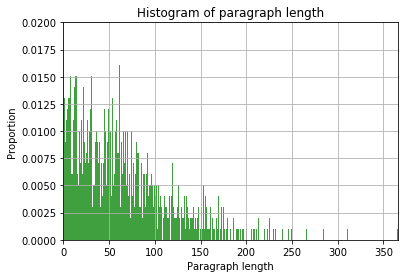

In [131]:
# plot the histogram of the paragraph length (= number of words) in the dataset
p_len = df.p_len.tolist()
max_len = max(df.p_len.tolist())
n, bins, patches = plt.hist(p_len, max_len, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Paragraph length')
plt.ylabel('Proportion')
plt.title('Histogram of paragraph length')
plt.axis([0, max_len, 0, 0.02])
plt.grid(True)

plt.show()

In [132]:
print(df.shape)
print(df[df.p_len<16].shape)
print(df[df.p_len>500].shape)

(1000, 4)
(175, 4)
(0, 4)


In [133]:
# Keep only rows with paragraphs having 15+words
df = df[df.p_len>15]

In [134]:
# set back y labels to appropriate format
q_text_clean = df.q_text
p_text_clean = df.p_text

labels = df['labels'].values
y_clean=[]
for i in range(len(labels)):
    if labels[i]==1:
        y_clean.append([0, 1])
    elif labels[i]==0:
        y_clean.append([1, 0])
    else:
        print('label value not in [0,1]') 

In [135]:
# save cleaned datasets, do the same for medium and full.
q_text_clean.values.dump("../data/clean_balanced_full_fold0_600K_query_text.csv")
p_text_clean.values.dump("../data/clean_balanced_full_fold0_600K_paragraph_text.csv")
np.array(y_clean).dump("../data/clean_balanced_full_fold0_600K_labels.csv")